In [10]:
import h5py
import numpy as np
import pandas as pd
import tables
import os
import sys
import time
import glob
import scipy.io as sio
import hdf5_getters
from pandas import read_hdf
# from musixmatch import Musixmatch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn import linear_model
import matplotlib.pyplot as plt

In [2]:
newDF = pd.read_pickle("finalLyricsData")
lyricsTokenDF = pd.read_pickle("tokenizedDF")


In [5]:
newDF_withall = newDF.drop(['track_id','musixIndex','lyrics','danceability', 'energy'],axis=1)

In [40]:
from sklearn.decomposition import PCA
justLyrics = np.transpose(lyricsTokenDF.drop(columns=['y']))
pca = PCA(n_components=100)
print(pca.fit(justLyrics))
print(pca.explained_variance_)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[4.82915013 1.8005586  1.68018689 1.52084247 1.23700455 1.15892881
 1.02707289 0.94627583 0.91706778 0.83070844 0.71974066 0.69240375
 0.59777826 0.54300777 0.50399966 0.47333758 0.42491719 0.4191543
 0.39359048 0.38186649 0.37619093 0.35462944 0.32753269 0.3115587
 0.29511247 0.29047379 0.28092188 0.27094604 0.2585423  0.25515465
 0.24670075 0.24146913 0.23573383 0.23178757 0.2292323  0.22594367
 0.21264209 0.21080814 0.20582673 0.20047935 0.19849956 0.19482042
 0.18637202 0.18536258 0.17994043 0.174802   0.1706716  0.16921437
 0.166289   0.16138151 0.15826733 0.15433896 0.15254136 0.14968928
 0.1476642  0.14504778 0.14223432 0.14102439 0.13626861 0.13441938
 0.1316517  0.13085429 0.12865335 0.12641026 0.12556813 0.12312521
 0.12130142 0.12020214 0.11999131 0.11692817 0.11581194 0.11488138
 0.11248397 0.11153199 0.11044837 0.10942352 0.10743996 0.10602839
 0.10516303 

[0.08952436 0.03337934 0.03114785 0.02819387 0.02293199 0.0214846
 0.01904021 0.01754237 0.0170009  0.01539994 0.01334279 0.01283601
 0.01108181 0.01006646 0.00934331 0.00877489 0.00787725 0.00777042
 0.00729651 0.00707917 0.00697395 0.00657424 0.00607191 0.00577578
 0.00547089 0.0053849  0.00520782 0.00502289 0.00479294 0.00473014
 0.00457342 0.00447643 0.00437011 0.00429695 0.00424958 0.00418862
 0.00394203 0.00390803 0.00381568 0.00371655 0.00367985 0.00361164
 0.00345503 0.00343631 0.00333579 0.00324054 0.00316397 0.00313695
 0.00308272 0.00299174 0.00293401 0.00286119 0.00282786 0.00277499
 0.00273745 0.00268894 0.00263679 0.00261436 0.00252619 0.00249191
 0.0024406  0.00242582 0.00238502 0.00234343 0.00232782 0.00228254
 0.00224873 0.00222835 0.00222444 0.00216765 0.00214696 0.00212971
 0.00208526 0.00206762 0.00204753 0.00202853 0.00199176 0.00196559
 0.00194955 0.0019396  0.00192408 0.00187397 0.00185033 0.00184137
 0.00181094 0.00179684 0.00177612 0.00175806 0.00174707 0.00171

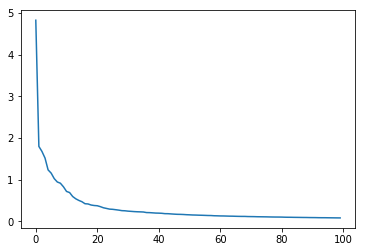

(2326, 100)
(2326, 4593)


In [43]:
print(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_)
# print(np.sum(pca.explained_variance_))
# print(np.sum(pca.explained_variance_[:100]))
plt.show()
#100 componenets explain 62.38 variance and total variance is 102.07
pcaComponents = np.transpose(pca.components_)
print(pcaComponents.shape)
print(lyricsTokenDF.shape)
# lyricsTokenDF

In [62]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
##Testing and training losses:
##Default adaboost regressor with square loss trained with 100 pca components:
####Train MSE: 139.9
####Train AMSE: 269.4
####Test MSE: 158.06
####Test AMSE: 963.018
##Default adaboost regressor with linear loss trained with 100 pca components:
####Train MSE: 173.77
####Train AMSE: 233.12
####Test MSE: 212.3
####Test AMSE: 980.94
##Default adaboost regressor with linear loss trained with original lyrics dataframe:
####Train MSE: 283.25
####Train AMSE: 401.85
####Test MSE: 287.18
####Test AMSE: 960.79
##Default adaboost regressor with square loss trained with original lyrics dataframe:
####Train MSE: 289.30
####Train AMSE: 356.99
####Test MSE: 323.95
####Test AMSE: 1002.27
##Default adaboost regressor with square loss trained with newDF_withall:
####Train MSE: 109.02
####Train AMSE: 208.60
####Test MSE: 142.98
####Test AMSE: 1020.71
##Default adaboost regressor with linear loss trained with newDF_withall:
####Train MSE: 157.71
####Train AMSE: 247.41
####Test MSE: 161.67
####Test AMSE: 601.66
abr = AdaBoostRegressor(loss='linear')
# print(newDF_withall.columns.values)
x_train, x_test, y_train, y_test = train_test_split(newDF_withall.drop(columns=['year']), newDF_withall['year'], test_size=0.2)
abr.fit(x_train, y_train)
y_trainpred = abr.predict(x_train)
print(mean_squared_error(y_train,y_trainpred))
print(adjusted_mean_squared_error(y_train,y_trainpred))
y_testpred = abr.predict(x_test)
print(mean_squared_error(y_test,y_testpred))
print(adjusted_mean_squared_error(y_test,y_testpred))

157.71871498534404
247.41530527870904
161.6698140407824
601.6565260508681


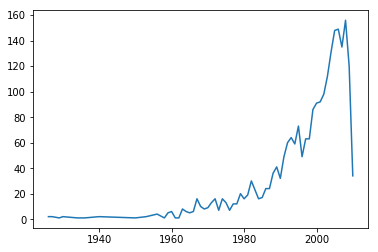

In [82]:
##Constructing a weight-adjusted loss function
from collections import Counter
counts = Counter(newDF_withall['year']).items()
countDataFrame = pd.DataFrame(data=counts)
countDataFrame.sort_values(0,inplace=True)
# print(countDataFrame)
plt.plot(countDataFrame[0], countDataFrame[1])
plt.show()
weights = [1/countDataFrame]


# def find_weight(y_true):
    

In [66]:
############## NAIVE REGRESSION MODEL (predicting 1997 for every one is the best) ###################
bestPred = 0
bestErr = 10000000000
numPoints = len(newDF['year'])
for tPred in range(1980,2010):
    tempErr = mean_squared_error(np.repeat(tPred,numPoints),newDF['year'])
    if tempErr < bestErr:
        bestErr = tempErr
        bestPred = tPred
print(adjusted_mean_squared_error(np.repeat(tPred,numPoints),newDF['year']))
print(bestPred, bestErr)

288.50171969045573
1997 143.8310404127257


In [48]:
############## SET UP TOKEN VECTORIZER ##################

tokenizer = TreebankWordTokenizer()
vectorizer_count = CountVectorizer(analyzer = "word", preprocessor = None, 
                                   stop_words='english', min_df=8, max_df=0.5, tokenizer=tokenizer.tokenize) 
vectorizer_tfid = TfidfVectorizer(max_df=0.5,min_df=8,stop_words='english')

# include 1-grams and 2-grams
#vectorizer.set_params(ngram_range=(1, 2))

train_data_features_tfid = vectorizer_tfid.fit_transform(newDF["lyrics"])
train_data_features_count = vectorizer_count.fit_transform(newDF["lyrics"])

# Numpy arrays are easy to work with, so convert the result to an 
# array
#train_data_features = train_data_features.toarray()
# see final the clean data
#print (train_data_features.shape)

In [49]:
######### FOR SOME REASON PCA DOESN'T WORK WHEN USING TfidfVectorizer BUT IT WORKED WITH CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt

maxComp = min(train_data_features_tfid.shape)
#pca = PCA(n_components=maxComp-1)
svd = TruncatedSVD(n_components=maxComp-1)
#pca.fit(train_data_features)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
svd.fit(train_data_features_tfid)
#pca.fit(train_data_features_count)
#plt.figure()
#plt.scatter(np.arange(40), svd.explained_variance_ratio_[0:40])
#plt.figure(1)
#plt.scatter(np.arange(x.shape[0])[0:40], pca.explained_variance_ratio_[0:40])
# could maybe do ten?

def select_n_components(var_ratio, goal_var: float):
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

print(select_n_components(svd.explained_variance_ratio_, 0.6)) # "Multivariate Analysis" by Hair et al (2012). the acceptable variance explained in factor analysis for a construct to be valid is sixty per cent.
print(select_n_components(svd.explained_variance_ratio_, 0.25))
tTrans = svd.transform(train_data_features_tfid)
newLyricsTransform = pd.DataFrame(tTrans).drop(np.arange(58,len(tTrans[0])), axis=1)

273
57


In [50]:
############### NEW DATAFRAME WITH ALL INFO FROM COMPRESSED LYRICS (25% VARIANCE EXPLAINED) AND MUSIC FEATURES
newDF_withall = newDF.drop(['track_id','musixIndex','lyrics','danceability', 'energy'],axis=1)
newDF_withall = newDF_withall.set_index(np.arange(newDF_withall.shape[0]))
newDF_withall = pd.concat([newDF_withall, newLyricsTransform], axis=1, sort=False)
newDF_withall.fillna(newDF_withall.mean(), inplace=True)

newDF_withall.shape

(2326, 92)

In [ ]:
### ADABOOST REGRESSOR


In [ ]:
############### COULD TRY RUNNING REGRESSION MODELS ON BOTH THE LYRICS AND MUSIC FEATURES SEPARATELY
############### (SHOULDN'T COMPRESS LYRICS AS MUCH AS IN MAIN DATAFRAME (MAYBE USE 60% OR SOMETHING))



Text(0.5,0,'n_components')

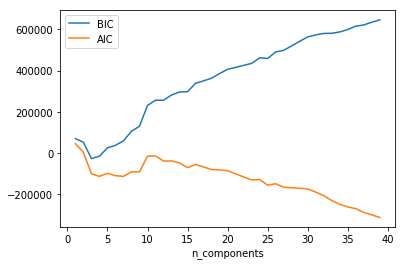

In [71]:
################# FITTING MIXTURE MODEL FOR WHOLE DATA (GAUSSIAN MIXTURE)
from sklearn.mixture import GaussianMixture


n_components = np.arange(1, 40)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(newDF_withall.drop('year',axis=1))
          for n in n_components]
plt.figure(0)
plt.plot(n_components, [m.bic(newDF_withall.drop('year',axis=1)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(newDF_withall.drop('year',axis=1)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

############## SEEMS LIKE 9 COMPONENTS MAY BE THE MOVE


In [82]:
################ CLUSTER TO FIT IDEAL 9 COMPONENTS AND THEN FIT MODEL WITH THOSE COMPONENTS
from keras.models import Sequential
from keras.layers import Dense

gMM = GaussianMixture(n_components = 9, covariance_type='full', random_state=0)
thePreds1 = gMM.fit_predict(newDF_withall.drop('year',axis=1))

clusterDF1 = pd.DataFrame({"cluster": thePreds1, "year":newDF_withall['year']})
x_train_clust1, x_test_clust1, y_train_clust1, y_test_clust1 = train_test_split(clusterDF1.drop('year',axis=1), clusterDF1['year'], test_size=0.2)

from sklearn import tree
treeMod = tree.DecisionTreeRegressor()
treeMod.fit(x_train_clust1, y_train_clust1)

mean_squared_error(y_test_clust1,treeMod.predict(x_test_clust1))




134.8150372798868

In [31]:
def adjusted_mean_squared_error(y_true, y_predict):
    #determine MSE for each decade and then take the average
    #this helps to adjust for the fact that our dataset is heavily concentrated in 2000
    (lower, upper) = (min(y_true), max(y_true))
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    np.reshape(y_true, (len(y_true)))
    np.reshape(y_predict, (len(y_predict)))
    decades = range(int(np.floor(lower/10)*10), int(np.floor(upper)), 10)
    mse = []
    for decade in decades:
        filter = [a >= decade and a < decade+10 for a in y_true]
        if(len(y_true[filter]) > 0):
            mse.append(mean_squared_error(y_true[filter], y_predict[filter]))
    return np.average(mse)

# adjusted_mean_squared_error(y_train, regRidge.predict(x_train))

In [66]:
################ TRAIN MODELS
regRidge = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3)
regRidge.fit(x_train, y_train)
trainMSE_ridge = adjusted_mean_squared_error(y_train, regRidge.predict(x_train))
testMSE_ridge = adjusted_mean_squared_error(y_test, regRidge.predict(x_test))

regLasso = linear_model.Lasso(alpha=0.1)
regLasso.fit(x_train, y_train)
trainMSE_lasso = adjusted_mean_squared_error(y_train, regLasso.predict(x_train))
testMSE_lasso = adjusted_mean_squared_error(y_test, regLasso.predict(x_test))

print("Ridge train: ", trainMSE_ridge, "Ridge test: ", testMSE_ridge)
print("Lasso train: ", trainMSE_lasso, "Lass test: ", testMSE_lasso)

Ridge train:  197.44975832661282 Ridge test:  1172.3354272425797
Lasso train:  1234.8480466533938 Lass test:  1114.368225760118


In [13]:
# regRidge.predict(x_train)
(min(y_train), max(y_train))

2010.0

In [8]:
############## Dimension Reduction for bag of words (PCA)
from sklearn.svm import SVR

clf = SVR(gamma='scale') #SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(x_train, y_train)
print(mean_squared_error(y_train, clf.predict(x_train)))
print(mean_squared_error(y_test, clf.predict(x_test)))

144.91047823764416
182.26448501943278


In [15]:
np.sum(y_train>1990)

1473

In [24]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
nFeat = x_train.shape[1]
model.add(Dense(1000, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(500, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=32)
#print(mean_squared_error(y_train, model.predict(x_train)))
#print(mean_squared_error(y_test, model.predict(x_test)))

Epoch 1/10
1860/1860 [==============================] - 3s 1ms/step - loss: 2401564.5747
Epoch 2/10
1860/1860 [==============================] - 2s 1ms/step - loss: 761037.8224
Epoch 3/10
1860/1860 [==============================] - 2s 1ms/step - loss: 405988.2618
Epoch 4/10
1860/1860 [==============================] - 2s 1ms/step - loss: 209482.3632
Epoch 5/10
1860/1860 [==============================] - 2s 1ms/step - loss: 104899.6081
Epoch 6/10
1860/1860 [==============================] - 2s 1ms/step - loss: 57705.9515
Epoch 7/10
1860/1860 [==============================] - 2s 1ms/step - loss: 36280.3551
Epoch 8/10
1860/1860 [==============================] - 2s 1ms/step - loss: 24196.5698
Epoch 9/10
1860/1860 [==============================] - 2s 1ms/step - loss: 17942.2961
Epoch 10/10
1860/1860 [==============================] - 2s 1ms/step - loss: 16119.1963


array([[1946.5184],
       [1744.9718],
       [1990.0282],
       ...,
       [1919.7136],
       [1989.7479],
       [2019.7651]], dtype=float32)

In [25]:
print(model.predict(x_train))
print(mean_squared_error(y_train, model.predict(x_train)))
print(mean_squared_error(y_test, model.predict(x_test)))

[[1946.5184]
 [1744.9718]
 [1990.0282]
 ...
 [1919.7136]
 [1989.7479]
 [2019.7651]]
14615.4120401605
381550.84935210913


In [ ]:
############## TOKENIZE TESTING DATA AND THEN MAKE PREDICTIONS
#X_test_vect = vectorizer.transform(x_test)

predicted = theModel.predict(x_test)


In [62]:
finalDataFrame = newDF.drop(["track_id","musixIndex", "lyrics"],axis=1)
finalDataFrame = finalDataFrame.set_index(np.arange(newDF.shape[0]))

In [63]:
finalDataFrame = pd.concat([finalDataFrame, PCALyrics], axis=1, sort=False)

,artist_hotttnesss,danceability,duration,end_of_fade_in,energy,key,loudness,mode,song_hotttnesss,tempo,...,615,616,617,618,619,620,621,622,623,624
0,0.434860,0.0,252.99546,0.514,0.0,1.0,-11.061,0.0,0.475638,80.084,...,0.071945,-0.257032,-0.196539,0.293499,-0.090210,-0.008033,-0.063375,-0.091004,-0.023878,-0.152406
1,0.334520,0.0,163.63057,0.000,0.0,7.0,-5.795,1.0,NaN,77.150,...,0.106758,-0.030016,-0.204888,-0.081121,-0.086589,0.024623,0.020169,-0.202278,-0.147184,0.137444
2,0.539245,0.0,216.84200,0.000,0.0,10.0,-4.264,1.0,0.788388,92.897,...,0.041058,-0.032635,-0.087466,-0.047189,-0.054714,0.040012,-0.166939,0.152990,0.318973,-0.200929
3,0.592439,0.0,218.90567,0.000,0.0,0.0,-4.707,0.0,0.681092,157.715,...,-0.029487,-0.151878,0.157312,-0.086829,0.024325,0.144210,-0.169575,0.266788,0.334551,0.293172
4,0.455559,0.0,283.48036,0.113,0.0,0.0,-4.076,0.0,0.687874,84.992,...,-0.050722,-0.062439,0.067779,-0.073572,-0.116098,0.100691,0.049677,0.043782,-0.046400,0.104637
5,0.791143,0.0,208.95302,3.245,0.0,4.0,-6.052,1.0,0.872229,105.095,...,-0.145900,0.100286,0.000739,0.013310,-0.072774,0.088626,0.122783,0.183677,-0.259670,-0.108917
6,0.578302,0.0,154.93179,0.107,0.0,5.0,-15.433,0.0,0.596841,100.042,...,0.136758,0.125596,-0.089743,0.011098,-0.007018,-0.029027,-0.111789,-0.012239,0.004903,-0.090266
7,0.481656,0.0,199.96689,0.450,0.0,5.0,-20.172,1.0,NaN,110.100,...,0.046465,0.089363,0.180623,-0.047567,0.139121,-0.042693,-0.115458,0.064821,-0.090276,-0.035782
8,0.411546,0.0,319.84281,0.000,0.0,3.0,-4.325,0.0,0.624834,92.971,...,-0.151781,0.191513,0.166944,0.123518,-0.274576,0.077000,0.168240,0.077520,-0.122940,-0.146868
9,0.459660,0.0,258.16771,0.000,0.0,11.0,-5.193,1.0,0.427447,117.936,...,0.098311,0.019971,-0.108096,-0.147739,-0.129239,-0.021527,-0.209052,-0.185252,-0.074520,0.110015


In [69]:
print(np.sum(finalDataFrame["danceability"]!=0))
print(np.sum(finalDataFrame["energy"]!=0))
#finalDataFrame["energy"]
finalDataFrame = finalDataFrame.drop(["danceability", "energy"], axis=1)

0
0


In [106]:
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
def eigenDecomposition(A, plot = True):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters 2


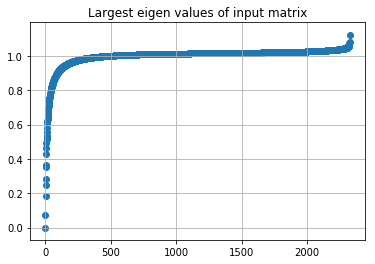

In [111]:
affinity_matrix = getAffinityMatrix(finalDataFrame.drop('year',axis=1), k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

In [125]:
myMix1 = GaussianMixture(15, covariance_type='full')
myMix2 = GaussianMixture(30, covariance_type='full')
thePreds1 = myMix1.fit_predict(finalDataFrame.drop('year',axis=1))
thePreds2 = myMix2.fit_predict(finalDataFrame.drop('year',axis=1))

In [128]:
clusterDF1 = pd.DataFrame({"cluster": thePreds1, "year":finalDataFrame['year']})
clusterDF2 = pd.DataFrame({"cluster": thePreds2, "year":finalDataFrame['year']})
x_train_clust1, x_test_clust1, y_train_clust1, y_test_clust1 = train_test_split(clusterDF1.drop('year',axis=1), clusterDF1['year'], test_size=0.2)
x_train_clust2, x_test_clust2, y_train_clust2, y_test_clust2 = train_test_split(clusterDF1.drop('year',axis=1), clusterDF1['year'], test_size=0.2)


x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(finalDataFrame.drop('year',axis=1), finalDataFrame['year'], test_size=0.2)


In [129]:
clusterLasso = linear_model.Lasso(alpha=0.1)
clusterLasso.fit(x_train_clust1, y_train_clust1)
trainMSE_lasso_clust1 = mean_squared_error(y_train_clust1, clusterLasso.predict(x_train_clust1))
testMSE_lasso_clust1 = mean_squared_error(y_test_clust1, clusterLasso.predict(x_test_clust1))

trainMSE_lasso_clust2 = mean_squared_error(y_train_clust2, clusterLasso.predict(x_train_clust2))
testMSE_lasso_clust2 = mean_squared_error(y_test_clust2, clusterLasso.predict(x_test_clust2))

print("Orig Lasso train: ", trainMSE_lasso, "Orig Lass test: ", testMSE_lasso)
print("15 Cluster Lasso train: ", trainMSE_lasso_clust1, "15 Cluster Lass test: ", testMSE_lasso_clust1)
print("Higher Cluster Lasso train: ", trainMSE_lasso_clust2, "Higher Cluster Lass test: ", testMSE_lasso_clust2)

regLasso = linear_model.Lasso(alpha=0.1)
regLasso.fit(x_train_new, y_train_new)
trainMSE_lasso = mean_squared_error(y_train_new, regLasso.predict(x_train_new))
testMSE_lasso = mean_squared_error(y_test_new, regLasso.predict(x_test_new))

print("New Lasso train: ", trainMSE_lasso, "New Lasso test: ", testMSE_lasso)

Orig Lasso train:  118.38365463195076 Orig Lass test:  160.01664946876272
15 Cluster Lasso train:  144.04490560627372 15 Cluster Lass test:  137.0874021101292
Higher Cluster Lasso train:  140.51179324802763 Higher Cluster Lass test:  151.1895243984075
New Lasso train:  119.46016530027815 New Lasso test:  92.02223887871465


In [134]:
model = Sequential()
nFeat = x_train_clust1.shape[1]
model.add(Dense(10, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(5, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
#model.add(Dense(1, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_clust1, y_train_clust1, epochs=175, batch_size=32)
print(mean_squared_error(y_train_clust1, model.predict(x_train_clust1)))
print(mean_squared_error(y_test_clust1, model.predict(x_test_clust1)))

Epoch 1/175
1860/1860 [==============================] - 0s 235us/step - loss: 3987844.9441
Epoch 2/175
1860/1860 [==============================] - 0s 25us/step - loss: 3986787.8790
Epoch 3/175
1860/1860 [==============================] - 0s 24us/step - loss: 3983188.2484
Epoch 4/175
1860/1860 [==============================] - 0s 24us/step - loss: 3974592.6989
Epoch 5/175
1860/1860 [==============================] - 0s 24us/step - loss: 3958560.0651
Epoch 6/175
1860/1860 [==============================] - 0s 24us/step - loss: 3932706.3849
Epoch 7/175
1860/1860 [==============================] - 0s 25us/step - loss: 3895449.1376
Epoch 8/175
1860/1860 [==============================] - 0s 25us/step - loss: 3844626.4699
Epoch 9/175
1860/1860 [==============================] - 0s 25us/step - loss: 3779401.5333
Epoch 10/175
1860/1860 [==============================] - 0s 24us/step - loss: 3698813.2140
Epoch 11/175
1860/1860 [==============================] - 0s 24us/step - loss: 3602516.6